In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp nodes

## Overview
A node comprises four functions, reference, perceptual, comparator and output. Executing the node will run each of the functions in the order indicated above and return the output value.

The functions can actually be a collection of functions, each executed in the order they are added. This allows a chain of functions in case pre-processing is required, or post-processing in the case of the output.

In [ ]:
#| export
import enum
import uuid
from pct.putils import UniqueNamer
from pct.putils import FunctionsList
from pct.putils import dynamic_module_import
from pct.functions import FunctionFactory
from pct.functions import HPCTFUNCTION

import json
from pct.functions import *

In [ ]:
#| export
class ControlUnitIndices(enum.IntEnum):
   PER_INDEX = 0
   OUT_INDEX = 1
   REF_INDEX = 2
   ACT_INDEX = 3

In [ ]:
#| export
class PCTNode():
    "A single PCT controller."
    def __init__(self, reference=None, perception=None, comparator=None, output=None, default=True, 
                 name="pctnode", history=False, build_links=False, mode=0, namespace=None, **pargs):
        # mode
        # 0 - per:var, ref:con, com:sub, out:prop
        # 1 - per:ws, ref:ws, com:sub, out:prop
        # 2 - per:ws, ref:con, com:sub, out:prop
        # 3 - per:ws, ref:ws, com:sub, out:ws
        # 4 - per:ws, ref:con, com:sub, out:ws
        # 5 - per:ws, ref:con, com:sub, out:smws
        # 6 - per:ws, ref:ws, com:sub, out:smws
        
        if namespace ==None:
            namespace = uuid.uuid1()
        self.namespace=namespace
        
        self.links_built = False
        self.history = None
        if history:
            self.history = PCTNodeData()
        self.name = UniqueNamer.getInstance().get_name(self.namespace, name)
        FunctionsList.getInstance().add_function(self.namespace, self)
        if default:
            if perception==None:
                perception = FunctionFactory.createFunctionWithNamespace(PCTNode.get_function_type(mode, HPCTFUNCTION.PERCEPTION), namespace=namespace)
            self.perceptionCollection = [perception]

            if reference==None:
                reference = FunctionFactory.createFunctionWithNamespace(PCTNode.get_function_type(mode, HPCTFUNCTION.REFERENCE), namespace=namespace)
            self.referenceCollection = [reference]

            if comparator==None:
                comparator = FunctionFactory.createFunctionWithNamespace(PCTNode.get_function_type(mode, HPCTFUNCTION.COMPARATOR), namespace=namespace)
            self.comparatorCollection = [comparator]

            if output==None:
                output = FunctionFactory.createFunctionWithNamespace(PCTNode.get_function_type(mode, HPCTFUNCTION.OUTPUT), namespace=namespace)
            self.outputCollection = [output]
            
            if build_links:
                self.build_links()
    
    def __call__(self, verbose=False):
        if not self.links_built:
            self.build_links()
            
        for referenceFunction in self.referenceCollection:
            referenceFunction(verbose)               

        for perceptionFunction in self.perceptionCollection:
            perceptionFunction(verbose)
                    
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction(verbose)

        for outputFunction in self.outputCollection:
            outputFunction(verbose)
            
        self.output = self.outputCollection[-1].get_value()
        
        if verbose:
            print()
            
        if not self.history == None:
            self.history.add_data(self)
            
        return self.output
    
    def __str__(self):
        return str(self.__dict__)
    
    def get_summary(self):
        
        for referenceFunction in self.referenceCollection:
            r= referenceFunction.output_string()               

        for perceptionFunction in self.perceptionCollection:
            p = perceptionFunction.output_string()
                    
        for comparatorFunction in self.comparatorCollection:
            c = comparatorFunction.output_string()

        for outputFunction in self.outputCollection:
            o = outputFunction.output_string()
        
        return " ".join((r, p, c, o))
    
    def set_name(self, name):
        self.name=name
    
    def get_name(self):
        return self.name

    def get_function_from_collection(self, collection, position=-1):
        if collection == HPCTFUNCTION.REFERENCE:
            func = self.referenceCollection[position]
            return func 

        if collection == HPCTFUNCTION.PERCEPTION:
            func = self.perceptionCollection[position]
            return func 
 
        if collection == HPCTFUNCTION.COMPARATOR:
            func = self.comparatorCollection[position]
            return func 
        
        if collection == HPCTFUNCTION.OUTPUT:
            func = self.outputCollection[position]
            return func 
        
        return func 
    
    def reset(self):
        for func in self.referenceCollection:
            func.reset_value()               

        for func in self.perceptionCollection:
            func.reset_value()               
                    
        for func in self.comparatorCollection:
            func.reset_value()              

        for func in self.outputCollection:
            func.reset_value()               
    

    
    def delete_contents(self):
        for func in self.referenceCollection:
            FunctionsList.getInstance().delete_function(func.namespace, func.name)

        for func in self.perceptionCollection:
            FunctionsList.getInstance().delete_function(func.namespace, func.name)
                    
        for func in self.comparatorCollection:
            FunctionsList.getInstance().delete_function(func.namespace, func.name)

        for func in self.outputCollection:
            FunctionsList.getInstance().delete_function(func.namespace, func.name)
            
    def reset_checklinks(self, val=True):
        for func in self.referenceCollection:
            func.reset_checklinks(val)               

        for func in self.perceptionCollection:
            func.reset_checklinks(val)               
                    
        for func in self.comparatorCollection:
            func.reset_checklinks(val)               

        for func in self.outputCollection:
            func.reset_checklinks(val)               
                    

    def get_function(self, collection, position=-1):
        if collection == "reference":
            func = self.referenceCollection[position]

        if collection == "perception":
            func = self.perceptionCollection[position]
 
        if collection == "comparator":
            func = self.comparatorCollection[position]
        
        if collection == "output":
            func = self.outputCollection[position]
        
        return func 

    def get_perception_value(self, position=-1):
        return self.perceptionCollection[position].get_value()
    
    def set_perception_value(self, value, position=-1):
        self.perceptionCollection[position].set_value(value)
    
    def add_link(self, collection, link):
        if collection == "reference":
            self.referenceCollection[0].add_link(link)

        if collection == "perception":
            self.perceptionCollection[0].add_link(link)
 
        if collection == "comparator":
            self.comparatorCollection[-1].add_link(link)
        
        if collection == "output":
            self.outputCollection[-1].add_link(link)
            
    # build links between each other in a collection, between com and ref/per and from out to com
    def build_links(self):
        if len(self.referenceCollection)>0:
            link = self.referenceCollection[0]
            for i in range (1, len(self.referenceCollection)):
                self.referenceCollection[i].add_link(link)               
                link = self.referenceCollection[i]

        if len(self.perceptionCollection)>0:
            link = self.perceptionCollection[0]
            for i in range (1, len(self.perceptionCollection)):
                self.perceptionCollection[i].add_link(link)               
                link = self.perceptionCollection[i]

        self.comparatorCollection[0].add_link(self.referenceCollection[-1])
        self.comparatorCollection[0].add_link(self.perceptionCollection[-1])

        if len(self.comparatorCollection)>1:
            link = self.comparatorCollection[1]
            for i in range (1, len(self.comparatorCollection)):
                self.comparatorCollection[i].add_link(link)               
                link = self.comparatorCollection[i]

        self.outputCollection[0].add_link(self.comparatorCollection[-1])

        if len(self.outputCollection)>0:
            link = self.outputCollection[0]
            for i in range (1, len(self.outputCollection)):
                self.outputCollection[i].add_link(link)               
                link = self.outputCollection[i]

        self.links_built = True

    def run(self, steps=None, verbose=False):
        for i in range(steps):
            out = self(verbose)
        return out
    
    def set_output(self, value):
        self.outputCollection[-1].set_value(value)
        
    def get_output_function(self):
        return self.outputCollection[-1]

    def get_reference_function(self):
        return self.referenceCollection[-1]

    def get_perception_function(self):
        return self.perceptionCollection[-1]

    def set_reference(self, value):
        self.referenceCollection[-1].set_value(value)

    
    def set_function_name(self, collection, name, position=-1):
        if collection == "reference":
            self.referenceCollection[position].set_name(name)

        if collection == "perception":
            self.perceptionCollection[position].set_name(name)
 
        if collection == "comparator":
            self.comparatorCollection[position].set_name(name)
        
        if collection == "output":
            self.outputCollection[position].set_name(name)
            

    def replace_function(self, collection, function, position=-1):
        if collection == "reference":
            self.referenceCollection[position] = function

        if collection == "perception":
            self.perceptionCollection[position]  = function
 
        if collection == "comparator":
            self.comparatorCollection[position] = function
        
        if collection == "output":
            self.outputCollection[position] = function
            
        

    def insert_function(self, collection, function, position=-1):
        if collection == "reference":
            self.referenceCollection[position] = function

        if collection == "perception":
            self.perceptionCollection[position]  = function
 
        if collection == "comparator":
            self.comparatorCollection[position] = function
        
        if collection == "output":
            self.outputCollection[position] = function


    def check_namespace(self, higher_namespace=None):

        if higher_namespace:
            if higher_namespace != self.namespace:
                print(self.name, type(self).__name__)
                print(f'This namespace {self.namespace} does not equal higher namespace {higher_namespace}')
                raise Exception(f'This namespace {self.namespace} does not equal higher namespace {higher_namespace}')

        for referenceFunction in self.referenceCollection:
            referenceFunction.check_namespace(higher_namespace=higher_namespace)   
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.check_namespace(higher_namespace=higher_namespace)
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.check_namespace(higher_namespace=higher_namespace)
        
        for outputFunction in self.outputCollection:
            outputFunction.check_namespace(higher_namespace=higher_namespace)

            
    def summary(self, build=True, extra=False, higher_namespace=None):
        if build:
            if not self.links_built:
                self.build_links()

        print(self.name, type(self).__name__, self.namespace)
        print("----------------------------")

        if higher_namespace:
            if higher_namespace != self.namespace:
                raise Exception(f'This namespace {self.namespace} does not equal higher namespace {higher_namespace}')

        print("REF:", end=" ")
        for referenceFunction in self.referenceCollection:
            referenceFunction.summary(extra=extra, higher_namespace=higher_namespace)   
        
        print("PER:", end=" ")
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.summary(extra=extra, higher_namespace=higher_namespace)
        
        print("COM:", end=" ")
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.summary(extra=extra, higher_namespace=higher_namespace)
        
        print("OUT:", end=" ")
        for outputFunction in self.outputCollection:
            outputFunction.summary(extra=extra, higher_namespace=higher_namespace)
        
        print("----------------------------")
        
        
    def graph(self, layer=0, layout={'r':2,'c':1,'p':2, 'o':0}):
        import networkx as nx

        graph = nx.DiGraph()
        
        self.set_graph_data(graph, layer=layer, layout=layout)
                
        return graph
    

    def validate(self, num_lower_perceptions=None, num_higher_outputs=None):
        
        if num_higher_outputs is not None:
            for func in self.referenceCollection:
                func.validate(num_higher_outputs)
                
        for func in self.perceptionCollection:
            func.validate(num_lower_perceptions)
    
    
    def clear_values(self):
        for referenceFunction in self.referenceCollection:
            referenceFunction.value = 0  
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.value = 0
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.value = 0
        
        for outputFunction in self.outputCollection:
            outputFunction.value  = 0
    
    def change_namespace(self, namespace):
        self.namespace=namespace
        
        name = self.name
        newname = UniqueNamer.getInstance().get_name(namespace, self.name)
        if name != newname:
            raise Exception(f'Names should not be different {name} {newname}')
        FunctionsList.getInstance().add_function(namespace, self)

        for referenceFunction in self.referenceCollection:
            referenceFunction.change_namespace(namespace)
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.change_namespace(namespace)
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.change_namespace(namespace)
        
        for outputFunction in self.outputCollection:
            outputFunction.change_namespace(namespace)
        
 
#     def set_graph_data_node(self, graph, layer=0):
#         graph.add_node(self.name, layer=layer)

#         for referenceFunction in self.referenceCollection:
#             referenceFunction.set_graph_data(graph, layer+2)   

#         for perceptionFunction in self.perceptionCollection:
#             perceptionFunction.set_graph_data(graph, layer+2)

            
    def set_graph_data(self, graph, layer=0, layout={'r':2,'c':1,'p':2, 'o':0}):
        
        for referenceFunction in self.referenceCollection:
            referenceFunction.set_graph_data(graph, layer+layout['r'])   
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.set_graph_data(graph, layer+layout['c'])
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.set_graph_data(graph, layer+layout['p'])
        
        for outputFunction in self.outputCollection:
            outputFunction.set_graph_data(graph, layer+layout['o'])

            
    def set_graph_data_funcdata(self, graph, layer=0, layout={'r':2,'c':1,'p':2, 'o':0}):
        
        for referenceFunction in self.referenceCollection:
            referenceFunction.set_graph_data_funcdata(graph, layer+layout['r'])   
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.set_graph_data_funcdata(graph, layer+layout['c'])
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.set_graph_data_funcdata(graph, layer+layout['p'])
        
        for outputFunction in self.outputCollection:
            outputFunction.set_graph_data_funcdata(graph, layer+layout['o'])
            
            
    def get_edge_labels(self, labels):

        for func in self.referenceCollection:
            func.get_weights_labels(labels)

        for func in self.comparatorCollection:
            func.get_weights_labels(labels)
                    
        for func in self.perceptionCollection:
            func.get_weights_labels(labels)
                    
        for func in self.outputCollection:
            func.get_weights_labels(labels)

    def get_edge_labels_funcdata(self, labels):

        for func in self.referenceCollection:
            func.get_weights_labels_funcdata(labels)

        for func in self.comparatorCollection:
            func.get_weights_labels_funcdata(labels)
                    
        for func in self.perceptionCollection:
            func.get_weights_labels_funcdata(labels)
                    
        for func in self.outputCollection:
            func.get_weights_labels_funcdata(labels)
            
            
    def get_node_list(self, node_list):
    
        for func in self.referenceCollection:
            node_list[func.get_name()] = self.name

        for func in self.comparatorCollection:
            node_list[func.get_name()] = self.name

        for func in self.perceptionCollection:
            node_list[func.get_name()] = self.name

        for func in self.outputCollection:
            node_list[func.get_name()] = self.name

    def get_parameters_list(self):
    
        ref_list = []
        for func in self.referenceCollection:
            ref_list.append(func.get_parameters_list())

        per_list = []
        for func in self.perceptionCollection:
            per_list.append(func.get_parameters_list())

        out_list = []
        for func in self.outputCollection:
            out_list.append(func.get_parameters_list())
            
        node_list = [ref_list, per_list, out_list]
            
        return node_list
        
    def change_link_name(self, old_name, new_name):

        for func in self.referenceCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for func in self.comparatorCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for func in self.perceptionCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for func in self.outputCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]
        
            
        
    def set_graph_data_node(self, graph, layer=0):
        graph.add_node(self.name, layer=layer)


    def graph_node(self, layer=0):
        graph = nx.DiGraph()

        self.set_graph_data_node(graph, layer=layer)

        return graph


    def draw_node(self, with_labels=True,  font_size=12, font_weight='bold', node_color='red',  
         node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(5,5), move={}):

        graph = self.graph_node()
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)        
        plt.figure(figsize=figsize)
        nx.draw(graph, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                node_color=node_color,  node_size=node_size, arrowsize=arrowsize)
        
        
        
    def draw(self, with_labels=True,  font_size=12, font_weight='bold', node_color='red',  
             node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(5,5), move={}):
        import networkx as nx        
        import matplotlib.pyplot as plt
        graph = self.graph()
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)        
        plt.figure(figsize=figsize)
        nx.draw(graph, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                node_color=node_color,  node_size=node_size, arrowsize=arrowsize)
        
    def get_config(self, zero=1):
        config = {"type": type(self).__name__,
                    "name": self.name}        

        coll_name = 'refcoll'
        collection = self.referenceCollection
        config[coll_name] = self.get_collection_config(coll_name, collection, zero)       
        coll_name = 'percoll'
        collection = self.perceptionCollection
        config[coll_name] = self.get_collection_config(coll_name, collection, zero)       
        coll_name = 'comcoll'
        collection = self.comparatorCollection
        config[coll_name] = self.get_collection_config(coll_name, collection, zero)       
        coll_name = 'outcoll'
        collection = self.outputCollection
        config[coll_name] = self.get_collection_config(coll_name, collection, zero)       
        
        return config       

    def get_collection_config(self, coll_name, collection, zero=1):
        coll = {}
        ctr=0
        for func in collection:
            coll[str(ctr)] = func.get_config(zero=zero)
            ctr+=1            
        return coll
    
    def save(self, file=None, indent=4):
        jsondict = json.dumps(self.get_config(), indent=indent)
        f = open(file, "w")
        f.write(jsondict)
        f.close()
        
    @classmethod
    def load(cls, file):      
        with open(file) as f:
            config = json.load(f)
        return cls.from_config(config, reference=True, comparator=True, perception=True, output=True)

    @classmethod
    def from_config(cls, config=None, namespace=None, node=None, reference=False, comparator=False, perception=False, output=False, history=False):
        "Create a node from JSON dictionary configuration."
        if node is None:
            node = PCTNode(default=False, name=config['name'], namespace=namespace, history=history)

        namespace= node.namespace

        if reference:
            node.referenceCollection = []
            collection = node.referenceCollection
            coll_dict = config['refcoll']
            PCTNode.collection_from_config(collection, coll_dict, namespace)

        if perception:
            node.perceptionCollection = []
            collection = node.perceptionCollection
            coll_dict = config['percoll']
            PCTNode.collection_from_config(collection, coll_dict, namespace)

        if comparator:
            node.comparatorCollection = []
            collection = node.comparatorCollection
            coll_dict = config['comcoll']
            PCTNode.collection_from_config(collection, coll_dict, namespace)

        if output:
            node.outputCollection = []
            collection = node.outputCollection
            coll_dict = config['outcoll']
            PCTNode.collection_from_config(collection, coll_dict, namespace)

        node.links_built = True
        return node
    
#     @classmethod
#     def from_config(cls, config, namespace=None, history=False):
            
#         node = PCTNode(default=False, name=config['name'], namespace=namespace, history=history)
#         namespace= node.namespace 
#         node.referenceCollection = []        
#         collection = node.referenceCollection
#         coll_dict = config['refcoll']
#         PCTNode.collection_from_config(collection, coll_dict, namespace)

#         node.perceptionCollection = []
#         collection = node.perceptionCollection
#         coll_dict = config['percoll']
#         PCTNode.collection_from_config(collection, coll_dict, namespace)
        
#         node.comparatorCollection = []
#         collection = node.comparatorCollection
#         coll_dict = config['comcoll']
#         PCTNode.collection_from_config(collection, coll_dict, namespace)

#         node.outputCollection = []
#         collection = node.outputCollection
#         coll_dict = config['outcoll']
#         PCTNode.collection_from_config(collection, coll_dict, namespace)
        
#         node.links_built = True
#         return node
    
    @classmethod
    def collection_from_config(node, collection, coll_dict, namespace):
        #print("collection_from_config", coll_dict)
        for fndict_label in coll_dict:
            #print("fndict_label",fndict_label)
            
            fndict = coll_dict[fndict_label]
            #print(fndict)
            fnname = fndict.pop('type')
            if fnname.startswith("EA"):
                fnname = fnname.replace("EA", "")
            #print(fndict)
            #func = eval(fnname).from_config(fndict, namespace)
            func = FunctionFactory.createFunctionFromConfig(fnname, namespace, fndict)
            
            collection.append(func)
            
    @classmethod
    def get_function_type(cls, mode, function):
        type = 'WeightedSum'
       
        if function == HPCTFUNCTION.PERCEPTION:
            if mode == 0 :
                type = 'Variable'
                
        if function == HPCTFUNCTION.REFERENCE:
            if mode == 0 or mode == 2  or mode == 4  or mode == 5 :
                type = 'Constant'
            
        if function == HPCTFUNCTION.COMPARATOR:
            type = 'Subtract'
            
        if function == HPCTFUNCTION.OUTPUT:
            if mode < 3: 
                type = 'Proportional'
            elif mode == 5  or mode == 6 :
                type = 'SmoothWeightedSum'
                
        return type    

In [ ]:
#node = PCTNode()
#node.summary()

In [ ]:
#| export
class PCTNodeData():
    "Data collected for a PCTNode"
    def __init__(self, name="pctnodedata"):
        self.data = {
            "refcoll":{}, 
            "percoll":{},
            "comcoll":{}, 
            "outcoll":{}}
        
    
    def add_data(self, node):
        ctr = 0 
        
        self.add_collection( node.referenceCollection, "refcoll")
        self.add_collection( node.perceptionCollection, "percoll")
        self.add_collection( node.comparatorCollection, "comcoll")
        self.add_collection( node.outputCollection, "outcoll")

    def add_collection(self, collection, collname):
        for func in collection:            
            if self.data[collname].get(func.get_name()) == None:
                dlist=[]
                cdict={func.get_name():dlist}
                self.data[collname]=cdict
            else:
                dlist = self.data[collname][func.get_name()]
                
            dlist.append(func.get_value())

## Creating a Node

A node can be created simply.

In [ ]:
node = PCTNode()
node.summary()

pctnode PCTNode e2723476-b938-11ee-9ede-5c879c15de65
----------------------------
REF: constant Constant | 0 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  constant variable 
OUT: proportional Proportional | gain 1 | 0 | links  subtract 
----------------------------


That creates a node with default functions. Those are, a constant of 1 for the reference, a variable, with initial value 0, for the perception and a proportional function for the output, with a gain of 10.

A node can also be created by providing a name, and setting the history to True. The latter means that the values of all the functions are recorded during execution, which is useful for plotting the data later, as can be seen below. 

In [ ]:
dynamic_module_import( 'pct.functions', 'Constant')

In [ ]:
reference = Constant(1)
namespace=reference.namespace

In [ ]:
node = PCTNode(name="mypctnode", history=True, reference = reference, output=Proportional(10, namespace=namespace), namespace=namespace)
node.summary()

mypctnode PCTNode e281ebf9-b938-11ee-944f-5c879c15de65
----------------------------
REF: constant Constant | 1 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  constant variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------


Another way of creating a node is by first declaring the functions you want and passing them into the constructor.

In [ ]:
UniqueNamer.getInstance().clear()
r = Variable(0, name="velocity_reference")
p = Constant(10, name="constant_perception")
o = Integration(10, 100, name="integrator")
integratingnode = PCTNode(reference=r, perception=p, output=o, name="integratingnode", history=True)

Yet another way to create a node is from a text configuration.

In [ ]:
config_node = PCTNode.from_config({ 'name': 'mypctnode', 
    'refcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 10}}, 
    'percoll': {'0': {'type': 'Variable', 'name': 'velocity', 'value': 0.2, 'links': {}}}, 
    'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 1, 'links': {0: 'constant', 1: 'velocity'}}}, 
    'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 10, 'links': {0: 'subtract'}, 'gain': 10}}})
# config_node = PCTNode.from_config({ 'name': 'mypctnode1', 
#     'refcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 10}}, 
#     'percoll': {'0': {'type': 'Variable', 'name': 'velocity', 'value': 0.2, 'links': {}}}, 
#     'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 1, 'links': {0: 'constant', 1: 'velocity'}}}, 
#     'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 10, 'links': {0: 'subtract'}, 'gain': 10}}}, namespace=namespace)

## Viewing Nodes

The details of a node can be viewed in a number of ways, which is useful for checking the configuration. The summary method prints to the screen. The get_config method returns a string in a JSON format.

In [ ]:
integratingnode.summary()

integratingnode PCTNode e28f596d-b938-11ee-a963-5c879c15de65
----------------------------
REF: velocity_reference Variable | 0 
PER: constant_perception Constant | 10 
COM: subtract Subtract | 0 | links  velocity_reference constant_perception 
OUT: integrator Integration | gain 10 slow 100  | 0 | links  subtract 
----------------------------


In [ ]:
#print(integratingnode.get_config())
assert integratingnode.get_config() == {'type': 'PCTNode', 'name': 'integratingnode', 'refcoll': {'0': {'type': 'Variable', 'name': 'velocity_reference', 'value': 0, 'links': {}}}, 'percoll': {'0': {'type': 'Constant', 'name': 'constant_perception', 'value': 10, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'velocity_reference', 1: 'constant_perception'}}}, 'outcoll': {'0': {'type': 'Integration', 'name': 'integrator', 'value': 0, 'links': {0: 'subtract'}, 'gain': 10, 'slow': 100}}}
integratingnode.get_config()

{'type': 'PCTNode',
 'name': 'integratingnode',
 'refcoll': {'0': {'type': 'Variable',
   'name': 'velocity_reference',
   'value': 0,
   'links': {}}},
 'percoll': {'0': {'type': 'Constant',
   'name': 'constant_perception',
   'value': 10,
   'links': {}}},
 'comcoll': {'0': {'type': 'Subtract',
   'name': 'subtract',
   'value': 0,
   'links': {0: 'velocity_reference', 1: 'constant_perception'}}},
 'outcoll': {'0': {'type': 'Integration',
   'name': 'integrator',
   'value': 0,
   'links': {0: 'subtract'},
   'gain': 10,
   'slow': 100}}}

A node can also be viewed graphically as a network of connected nodes.

In [ ]:
import os

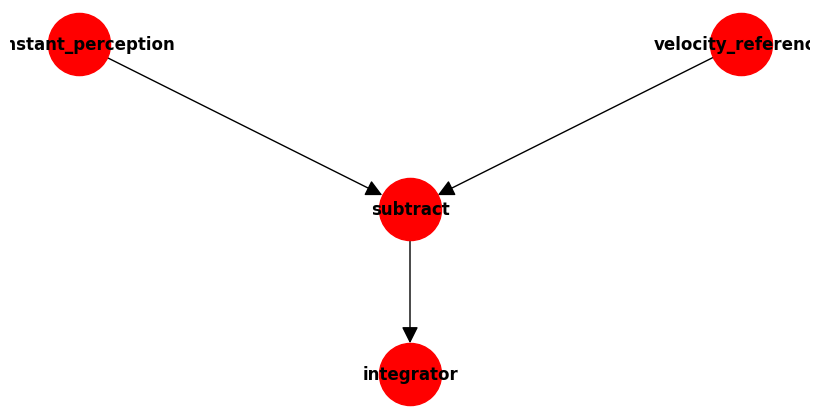

In [ ]:
if os.name=='nt':
    integratingnode.draw(node_size=2000, figsize=(8,4))

## Running a Node

For the purposes of this example we first create a function which is a very basic model of the physical environment. It defines how the world behaves when we pass it the output of the control system.  

In [ ]:
def velocity_model(velocity,  force , mass):
    velocity = velocity + force / mass
    return velocity

mass = 50
force = 0

In the following cell we start with a velocity of zero. The node is run once (second line), the output of which is the force to apply in the world velocity_model. That returns the updated velocity which we pass back into the node to be used in the next iteration of the loop.   

In [ ]:
velocity=0
force = node()
velocity = velocity_model(velocity, force, mass)
node.set_perception_value(velocity)
print(force)
assert force == 10

10


The node can be run in a loop as shown below. With verbose set to True the output of each loop will be printed to the screen.

In [ ]:
pctnode = PCTNode(history=True)
pctnode.set_function_name("perception", "velocity")
pctnode.set_function_name("reference", "reference")

for i in range(40):
    print(i, end=" ")
    force = pctnode(verbose=True)
    vel = velocity_model(pctnode.get_perception_value(), force, mass)
    pctnode.set_perception_value(vel)
    

0 0.000 0.000 0.000 0.000 
1 0.000 0.000 0.000 0.000 
2 0.000 0.000 0.000 0.000 
3 0.000 0.000 0.000 0.000 
4 0.000 0.000 0.000 0.000 
5 0.000 0.000 0.000 0.000 
6 0.000 0.000 0.000 0.000 
7 0.000 0.000 0.000 0.000 
8 0.000 0.000 0.000 0.000 
9 0.000 0.000 0.000 0.000 
10 0.000 0.000 0.000 0.000 
11 0.000 0.000 0.000 0.000 
12 0.000 0.000 0.000 0.000 
13 0.000 0.000 0.000 0.000 
14 0.000 0.000 0.000 0.000 
15 0.000 0.000 0.000 0.000 
16 0.000 0.000 0.000 0.000 
17 0.000 0.000 0.000 0.000 
18 0.000 0.000 0.000 0.000 
19 0.000 0.000 0.000 0.000 
20 0.000 0.000 0.000 0.000 
21 0.000 0.000 0.000 0.000 
22 0.000 0.000 0.000 0.000 
23 0.000 0.000 0.000 0.000 
24 0.000 0.000 0.000 0.000 
25 0.000 0.000 0.000 0.000 
26 0.000 0.000 0.000 0.000 
27 0.000 0.000 0.000 0.000 
28 0.000 0.000 0.000 0.000 
29 0.000 0.000 0.000 0.000 
30 0.000 0.000 0.000 0.000 
31 0.000 0.000 0.000 0.000 
32 0.000 0.000 0.000 0.000 
33 0.000 0.000 0.000 0.000 
34 0.000 0.000 0.000 0.000 
35 0.000 0.000 0.000 0.000 
36

## Save and Load

Save a node to file.

In [ ]:
import json

In [ ]:
integratingnode.save("inode.json")

Create a node from file.

In [ ]:
nnode = PCTNode.load("inode.json")
nnode.summary()
print(nnode.get_config())

integratingnode PCTNode 576b00b4-b939-11ee-9e11-5c879c15de65
----------------------------
REF: velocity_reference Variable | 0 
PER: constant_perception Constant | 10 
COM: subtract Subtract | 0 | links  velocity_reference constant_perception 
OUT: integrator Integration | gain 10 slow 100  | 0 | links  subtract 
----------------------------
{'type': 'PCTNode', 'name': 'integratingnode', 'refcoll': {'0': {'type': 'Variable', 'name': 'velocity_reference', 'value': 0, 'links': {}}}, 'percoll': {'0': {'type': 'Constant', 'name': 'constant_perception', 'value': 10, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'velocity_reference', 1: 'constant_perception'}}}, 'outcoll': {'0': {'type': 'Integration', 'name': 'integrator', 'value': 0, 'links': {0: 'subtract'}, 'gain': 10, 'slow': 100}}}


In [ ]:
print(nnode.get_summary())

0.000 10.000 0.000 0.000


## Plotting the Data

As the history of the variable pctnode was set to True the data is available for analysis. It can be plotted with python libraries such as matplotlib or plotly. Here is an example with the latter.

The graph shows the changing perception values as it is controlled to match the reference value.

```python
import plotly.graph_objects as go
fig = go.Figure(layout_title_text="Velocity Goal")
fig.add_trace(go.Scatter(y=pctnode.history.data['refcoll']['reference'], name="ref"))
fig.add_trace(go.Scatter(y=pctnode.history.data['percoll']['velocity'], name="perc"))
```

This following code is only for the purposes of displaying image of the graph generated by the above code.

In [ ]:
from IPython.display import Image

In [ ]:
Image(url='http://www.perceptualrobots.com/wp-content/uploads/2020/08/pct_node_plot.png') 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()